In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

from open_ephys.control import OpenEphysHTTPServer

In [20]:
class Npx2_Channel_Selector():
    """
    Class to handle channel selection for the Neuropixels 2 probes.

    The probe has 4 shanks, each with 2 columns of electrodes, spaced by 15/32 um in the y/x directions.
    Within each shank, there are ~3.33 banks of 384 electrodes.
    Within each bank, there are 8 channel groups of 48 electrodes.
    (These groups are always paired [tho unclear if this matters?], so the effective unit is 96, which we call a "row".)

    Currently implemented configurations:
    - linear_single_shank: Record from all 8 groups in a bank, on one particular shank.
    - dense_row: Record from a dense row across the probe (2 groups in each shank, in a given bank).
    - diagonal: Record from a diagonal line across the probe (2 groups in each shank, in a given bank).
    - double_tall: Record from a single-width column of contacts across two adjacent banks, on a single shank.
    
    UNTESTED configurations:
    - half_bank: Record from a half-bank (4 groups) on two adjacent shanks (0 and 1, or 2 and 3).
    - dense_row_offset: Record from a dense row across the probe, but offset by one half-group (ie starting w )
    """

    def __init__(self):
        self.n_shanks = 4
        self.n_banks_per_shank = 3.33
        self.shank_pitch_x = 250  # um
        self.shank_width_x = 70 # um
        self.shank_offsets_x = np.array([0, 250, 500, 750])

        # Channel group info
        self.n_groups_per_bank = 8
        self.n_groups_per_row = 2  # this is a bit hacky, but since the groups are paired, we'll treat them each pair as a "row".
        self.n_rows_per_bank = self.n_groups_per_bank // self.n_groups_per_row
        self.shank_1_order = [1, 3, 5, 7, 6, 8, 2, 4]
        self.shank_2_order = [2, 4, 6, 8, 5, 7, 1, 3]
        self.shank_3_order = [5, 7, 1, 3, 2, 4, 6, 8]
        self.shank_4_order = [6, 8, 2, 4, 1, 3, 5, 7]
        self.n_ch_per_group = 48

        # Electrode info per shank
        self.n_cols = 2
        self.dy = 15
        self.dx = 32
        self.n_elec_per_shank = 1280
        self.n_elec_per_bank = 384
        self.shank_electrode_ids = np.arange(self.n_elec_per_shank)
        self.shank_electrode_positions = np.zeros((self.n_elec_per_shank, 2))
        for i in range(self.n_elec_per_shank):
            self.shank_electrode_positions[i, 0] = (i % 2) * self.dx
            self.shank_electrode_positions[i, 1] = (i // 2) * self.dy
        
        # State info
        self.current_eids = []
        self.current_shanks = []
        self.current_eposns = []

    def oe_connect(self, processor_id, basestation, port, dock):
        self.gui = OpenEphysHTTPServer()
        self.oe_info = dict(
            processor_id=processor_id,
            basestation=basestation,
            port=port,
            dock=dock
        )
        cmd = f'NP INFO'  # Try to send a basic command to validate
        try:
            self.gui.config(processor_id, cmd)
        except:
            raise ValueError(f"Failed to connect to Open Ephys GUI.")
        try:
            self.gui.acquire(1)
        except:
            raise ValueError(f"Failed to acquire data stream.") 

    def oe_select_current_channels(self):
        """
        Select the current channels in the Open Ephys GUI.
        command is like: NP SELECT <bs> <port> <dock> <electrode> <electrode> <electrode> ...
        """
        if len(self.current_eids) == 0:
            raise ValueError("No electrodes selected.")
        
        # The pxi simply numbers the electrodes 1 2...1279 1280; 1281 1282...2559, 2560; etc.
        eids_pxi = [str(eid + sid * self.n_elec_per_shank) for eid,sid in zip(self.current_eids, self.current_shanks)]
        eids_pxi = ' '.join(eids_pxi)
        d = self.oe_info
        cmd = f'NP SELECT {d["basestation"]} {d["port"]} {d["dock"]} {eids_pxi}'
        self.gui.config(d["processor_id"], cmd)

    def eids_from_group(self, bank, group):
        """
        Get the electrode ids for a given bank and group.
        """
        return np.arange(48) + 48 * group + 384 * bank

    def eposns_from_group(self, shank, bank, group):
        """
        Get the electrode positions for a given shank, bank and group.
        """
        electrode_ids = self.eids_from_group(bank, group)
        shank_electrode_posns = self.shank_electrode_positions[electrode_ids]
        return shank_electrode_posns + np.array([self.shank_offsets_x[shank], 0])

    def set_linear_single_shank(self, shank, bank):
        """
        Record from all 8 groups in a bank, on one particular shank.
        """
        self.current_eids = [self.eids_from_group(bank, g) for g in range(self.n_groups_per_bank)] 
        self.current_eids = np.concatenate(self.current_eids)
        self.current_shanks = [shank] * 384
        posns_within_shank = self.shank_electrode_positions[self.current_eids, :]
        shank_offsets = np.array([self.shank_offsets_x[shank], 0])
        self.current_eposns = posns_within_shank + shank_offsets

    def set_half_bank(self, shanks, bank):
        """
        Record from a half-bank (4 groups) on two adjacent shanks (0 and 1, or 2 and 3).
        """
        self.current_eids = []
        self.current_shanks = []
        self.current_eposns = []
        assert len(shanks) == 2
        assert (shanks==[0,1] or shanks==[2,3])
        for shank in shanks:
            for group in range(4):
                these_eids = self.eids_from_group(bank, group)
                self.current_eids.append(these_eids)
                self.current_shanks.append([shank] * len(these_eids))
                posns_within_shank = self.shank_electrode_positions[these_eids, :]
                shank_offsets = np.array([self.shank_offsets_x[shank], 0])
                self.current_eposns.append(posns_within_shank + shank_offsets)

        self.current_eids = np.concatenate(self.current_eids)
        self.current_shanks = np.concatenate(self.current_shanks)
        self.current_eposns = np.concatenate(self.current_eposns, axis=0)

    def set_dense_row(self, bank, row_in_bank, offset=0):
        """
        Record from 2 groups in each shank, in a given bank.
        Each bank has 4 effective "rows" since the groups are paired.
        """
        if row_in_bank >= self.n_rows_per_bank:
            raise ValueError(f"Invalid row_in_bank: {row_in_bank}")
        self.current_eids = []
        self.current_shanks = []
        self.current_eposns = []
        for shank in range(self.n_shanks):
            for i in range(2):
                group = row_in_bank * 2 + i + offset
                these_eids = self.eids_from_group(bank, group)
                self.current_eids.append(these_eids)
                self.current_shanks.append([shank] * len(these_eids))
                posns_within_shank = self.shank_electrode_positions[these_eids, :]
                shank_offsets = np.array([self.shank_offsets_x[shank], 0])
                self.current_eposns.append(posns_within_shank + shank_offsets)

        self.current_eids = np.concatenate(self.current_eids)
        self.current_shanks = np.concatenate(self.current_shanks)
        self.current_eposns = np.concatenate(self.current_eposns, axis=0)

    def set_diagonal(self, bank, lower_side="left"):
        """
        Record from 2 groups in each shank, in a given bank.
        There are two possible diagonals: left or right.
        """
        # This can be done by taking groups indices 0 and 1 from shank 1,
        # 2 and 3 from shank 2, etc. The probe is designed such that this will always work.
        self.current_eids = []
        self.current_shanks = []
        self.current_eposns = []

        if lower_side == "left":
            shank_order = np.arange(self.n_shanks)
        elif lower_side == "right":
            shank_order = np.arange(self.n_shanks - 1, -1, -1)
        else:
            raise ValueError(f"Invalid lower_side: {lower_side}")

        for iShank, shank in enumerate(shank_order):
            groups_to_use = [2 * iShank, 2 * iShank + 1]
            for group in groups_to_use:
                these_eids = self.eids_from_group(bank, group)
                self.current_eids.append(these_eids)
                self.current_shanks.append([shank] * len(these_eids))
                posns_within_shank = self.shank_electrode_positions[these_eids, :]
                shank_offsets = np.array([self.shank_offsets_x[shank], 0])
                self.current_eposns.append(posns_within_shank + shank_offsets)
        
        self.current_eids = np.concatenate(self.current_eids)
        self.current_shanks = np.concatenate(self.current_shanks)
        self.current_eposns = np.concatenate(self.current_eposns, axis=0)

    def set_double_tall(self, shank, lower_bank):
        """
        Record from a single-width column of contacts across two adjacent banks, on a single shank.
        """
        self.current_eids = []
        self.current_shanks = []
        self.current_eposns = []

        banks_to_use = [lower_bank, lower_bank + 1]
        for iBank, bank in enumerate(banks_to_use):
            for group in range(self.n_groups_per_bank):
                these_eids = self.eids_from_group(bank, group)
                if iBank == 0:
                    these_eids = these_eids[::2]  # Take every other electrode to get a single column
                elif iBank == 1:
                    these_eids = these_eids[1::2]
                self.current_eids.append(these_eids)
                self.current_shanks.append([shank] * len(these_eids))
                posns_within_shank = self.shank_electrode_positions[these_eids, :]
                shank_offsets = np.array([self.shank_offsets_x[shank], 0])
                self.current_eposns.append(posns_within_shank + shank_offsets)

        self.current_eids = np.concatenate(self.current_eids)
        self.current_shanks = np.concatenate(self.current_shanks)
        self.current_eposns = np.concatenate(self.current_eposns, axis=0)
        
    def set_electrode_config(self, config, **kwargs):
        """
        Set the electrode configuration.
        """
        if config == 'linear_single_shank':
            self.set_linear_single_shank(**kwargs)
        elif config == 'dense_row':
            self.set_dense_row(**kwargs)
        elif config == 'diagonal':
            self.set_diagonal(**kwargs)
        elif config == 'double_tall':
            self.set_double_tall(**kwargs)
        elif config == 'half_bank':
            self.set_half_bank(**kwargs)
        elif config == 'dense_row_offset':
            self.set_dense_row(**kwargs, offset=1)
        else:
            raise ValueError(f"Unknown configuration: {config}")

    def plot(self):
        """
        Plot the current electrode configuration.
        """
        fig, ax = plt.subplots(figsize=(3, 2))

        # Draw the shanks as rectangles of height 1280 * self.dy, and width self.shank_pitch_x
        offset = self.shank_width_x//4
        max_y = self.shank_electrode_positions[-1, 1] + self.dy
        for shank in range(4):
            x = self.shank_offsets_x[shank] - offset
            ax.plot([x, x], [0, max_y], 'k')
            ax.plot([x + self.shank_width_x, x + self.shank_width_x], [0, max_y], 'k')
            ax.plot([x, x + self.shank_width_x], [0, 0], 'k')
            ax.plot([x, x + self.shank_width_x], [max_y, max_y], 'k')

        # Draw the currently selected electrodes
        ax.scatter(self.current_eposns[:, 0], self.current_eposns[:, 1], s=2)
        plt.ylabel('Y (um)')
        plt.xlabel('X (um)')
        plt.show()



In [21]:
npx = Npx2_Channel_Selector()

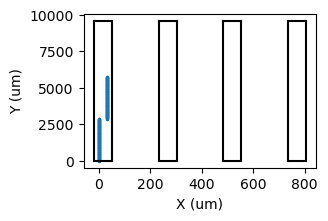

In [22]:
npx.set_electrode_config('double_tall', shank=0, lower_bank=0)
npx.plot()

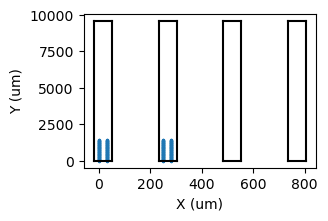

In [23]:
npx.set_electrode_config('half_bank', bank=0, shanks=[0,1])
npx.plot()

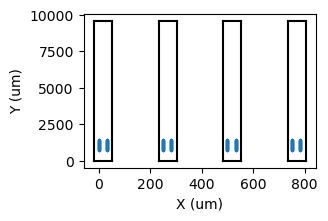

In [27]:
npx.set_electrode_config('dense_row', bank=0, row_in_bank=1)
npx.plot()

In [40]:
# import requests
# r = requests.get("http://localhost:37497/api/processors")
"""
'{"processors":[{"id":102,"name":"Bandpass Filter","parameters":[],"predecessor":106,"streams":[{"channel_count":384,"name":"ProbeA","parameters":[{"name":"enable_stream","type":"Boolean","value":"true"},{"name":"high_cut","type":"Float","value":"6000"},{"name":"low_cut","type":"Float","value":"300"},{"name":"Channels","type":"Mask Channels","value":""}],"sample_rate":30000.0,"source_id":105}]},{"id":104,"name":"Neuropixels CAR","parameters":[],"predecessor":102,"streams":[{"channel_count":384,"name":"ProbeA","parameters":[{"name":"enable_stream","type":"Boolean","value":"true"},{"name":"Channels","type":"Mask Channels","value":""}],"sample_rate":30000.0,"source_id":105}]},{"id":101,"name":"LFP Viewer","parameters":[],"predecessor":104,"streams":[{"channel_count":384,"name":"ProbeA","parameters":[{"name":"enable_stream","type":"Boolean","value":"true"}],"sample_rate":30000.0,"source_id":105}]},{"id":105,"name":"Neuropix-PXI","parameters":[],"predecessor":null,"streams":[{"channel_count":384,"name":"ProbeA","parameters":[],"sample_rate":30000.0,"source_id":105}]},{"id":106,"name":"Record Node","parameters":[],"predecessor":105,"streams":[{"channel_count":384,"name":"ProbeA","parameters":[{"name":"enable_stream","type":"Boolean","value":"true"}],"sample_rate":30000.0,"source_id":105}]}]}'
"""

# TODO: the processor ID can change seemingly at random.
# So whenever we're abt to do sth, ask for np info, and check that plugin is neuropix-pxi.
# if not, send request for processors and find id for the pxi and re-connect.

# npx.gui.config(105, "NP INFO")
"""
{'info': '{"plugin": "Neuropix-PXI", "version": "0.6.6", "probes": [{"name": "ProbeA", "type": "Neuropixels 2.0 - Multishank", "slot": 2, "port": 3, "dock": 1, "part_number": "NP2013", "serial_number": "22420014914", "is_calibrated": false}]}'}
"""

'\n{\'info\': \'{"plugin": "Neuropix-PXI", "version": "0.6.6", "probes": [{"name": "ProbeA", "type": "Neuropixels 2.0 - Multishank", "slot": 2, "port": 3, "dock": 1, "part_number": "NP2013", "serial_number": "22420014914", "is_calibrated": false}]}\'}\n'

In [41]:
npx.oe_connect(processor_id=107, basestation=2, dock=1, port=3)

In [42]:
npx.set_electrode_config('double_tall', shank=0, lower_bank=0)
npx.oe_select_current_channels()

In [37]:
rec_time_s = 300
# todo: figure out how to start a new session here
for shank in range(4):
    npx.set_electrode_config('double_tall', shank=shank, lower_bank=0)
    npx.oe_select_current_channels()
    time.sleep(1)
    npx.gui.record(rec_time_s)

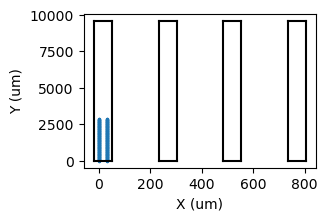

In [19]:
npx.set_electrode_config('linear_single_shank', shank=0, bank=0)
npx.plot()

In [21]:
npx.set_electrode_config('double_tall', shank=0, lower_bank=0)

In [21]:
npx.oe_select_current_channels()

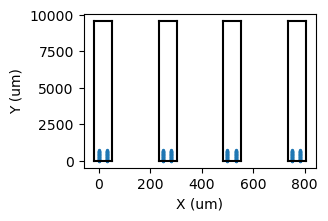

In [14]:
npx.set_electrode_config('dense_row', bank=0, row_in_bank=0)
npx.plot()

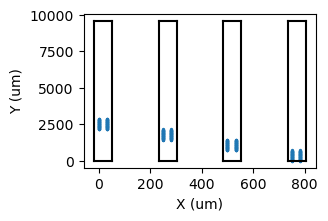

In [19]:
npx.set_electrode_config('diagonal', bank=0, lower_side="right")
npx.plot()
